## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
    * [Step 1 - Gathering Neighbourhoods](#Step1)
    * [Step 2 - Gathering Venues](#Step2)
* [Methodology](#methodology)
    * [Step 3 - Mapping Venues and Neighbourhoods](#Step3)
* [Analysis](#analysis)
    * [Step 4 - Graphing](#Step4)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

# Introduction: Business Problem <a name="introduction"></a>

We will try to find an optimal location for a bar in the Greater Toronto Area. This report will is targeted to potential investors interested in opening a **local bar/pub** in **Toronto**, Canada.y.

We will aim to find areas where there are a **high amount of restaurants** and a **low amount of bars**. We will also be looking into neighbourhoods that have a **high average income** and **high population density** (both relative to other neighbourhoods in Toronto.

By using data science, we will be able to visually see potential locations and then **further analyze** the results so ensure to our investors the certainty of our plan.

## Data <a name="data"></a>

Factors that will influence our decission are:
* number of existing bars/pubs in the neighborhood
* number of existing restaurants in the neighborhood
* average income in the neighborhood
* population density in the neighborhood

We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:
* coordinates of neighborhood centres using **Google Maps API geocoding** based off data scraped from Wikipedia
* number of bars and their type and location in every neighborhood will be obtained using **Foursquare API**
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**
* Average Income and Population density will be obtained using **Wikipedia**

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import rc

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

/bin/sh: conda: command not found
/bin/sh: conda: command not found
Libraries imported.


In [2]:
import requests
# use requests to extract data from foursquare
import lxml.html as lh
# use lxml.html to extract data from wikipedia

## Step 1 - Gathering Neighborhoods <a name="Step1"></a>

The first step was to gather the data for the potential Neighbourhoods. This would require scraping data for postal codes from one wikipedia page and the also gathering the average income and population density from another Wikipedia page.

The process would be to scrape data from Wikipedia, scrub it, and then add both DataFrames together.

In [3]:
# Used a prior code to extract the postal codes and neighborhoods in Canada

url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

#Create a handle, page, to handle the contents of the website
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

#Check the length of the first 12 rows
[len(T) for T in tr_elements[:12]]

#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    print('%d:%s'%(i,name))
    col.append((name,[]))
    
#Since out first row is the header, data is stored on the second row onwards
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 10, the //tr data is not from our table 
    if len(T)!=3:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1
        
#Check the length of each column
[len(C) for (title,C) in col]

#Create dictionary and DataFrame
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)
df.head()

df.rename(columns={'Postcode':'Postal Code','Neighbourhood\n':'Neighbourhood'}, inplace=True) #Change Neighbourhood\n to Neighbourhood
df = df.replace('\n','', regex=True) #get rid of all \n in the DataFrame
df = df.replace('Not assigned',np.nan, regex=True) #replace "Not Assigned" values to NaN
df.dropna(subset=['Borough'],inplace=True) #drop rows that have NaN in the 'Borough' column
df.shape

df['Neighbourhood'].fillna(df['Borough'], inplace=True) #fill NaN values in Neighbourhood with the corresponding Borough value
df.head()

1:Postcode
2:Borough
3:Neighbourhood



Postal Code           Borough     Neighbourhood
2         M3A        North York         Parkwoods
3         M4A        North York  Victoria Village
4         M5A  Downtown Toronto      Harbourfront
5         M5A  Downtown Toronto       Regent Park
6         M6A        North York  Lawrence Heights

In [4]:
df_toronto = pd.read_csv('http://cocl.us/Geospatial_data') # read the lat & long data from the url

In [5]:
df_toronto.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

In [6]:
# type your answer here
CLIENT_ID = 'Y1PZQ4UQX0XRYB5YMWSHH05PWS2F0R4S4SI4F05KIUJZ1JDX' # your Foursquare ID
CLIENT_SECRET = 'FFMOJY1UQXST5XXCTUIGWVLENGPG2VDDJIYF201YLOXUTG30' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version



In [7]:
# Loop to great a new list that contains longitude and latitude of the cities
URL = []
city = "Toronto, Canada"
limit = 100
radius = 5000

for i in range(len(df_toronto)):
    geolocator = Nominatim(user_agent="explorer")
    location = geolocator.geocode(city, timeout=10)
    latitude = df_toronto.loc[i,'Latitude']
    longitude = df_toronto.loc[i,'Longitude']
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION, 
        latitude, 
        longitude,
        radius,
        limit)
    URL.append([latitude, longitude, url])
    print(i, '', end='')
print('Done')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 Done


In [8]:
columns_temp = ['Latitude','Longitude','URL']
df_temp = pd.DataFrame(URL, columns=columns_temp)
df_toronto['URL Link'] = df_temp['URL']
df_toronto.head()

df3 = pd.merge(df, df_toronto, on=['Postal Code']) # Merge the two dataframes together
df3.head()

Postal Code           Borough     Neighbourhood   Latitude  Longitude  \
0         M3A        North York         Parkwoods  43.753259 -79.329656   
1         M4A        North York  Victoria Village  43.725882 -79.315572   
2         M5A  Downtown Toronto      Harbourfront  43.654260 -79.360636   
3         M5A  Downtown Toronto       Regent Park  43.654260 -79.360636   
4         M6A        North York  Lawrence Heights  43.718518 -79.464763   

                                            URL Link  
0  https://api.foursquare.com/v2/venues/explore?&...  
1  https://api.foursquare.com/v2/venues/explore?&...  
2  https://api.foursquare.com/v2/venues/explore?&...  
3  https://api.foursquare.com/v2/venues/explore?&...  
4  https://api.foursquare.com/v2/venues/explore?&...

In [24]:
# Used a prior code to extract the Demographics of Neighborhoods in Toronto, Canada

url='https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods'

#Create a handle, page, to handle the contents of the website
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

#Check the length of the first 12 rows
[len(T) for T in tr_elements[:12]]

#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in tr_elements[1]:
    i+=1
    name=t.text_content()
    print('%d:%s'%(i,name))
    col.append((name,[]))
    
#Since out first row is the header, data is stored on the second row onwards
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of a certain SIZE, the //tr data is not from our table 
    if len(T)!=13:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1
        
#Check the length of each column
[len(C) for (title,C) in col]

#Create dictionary and DataFrame
Dict={title:column for (title,column) in col}
df_raw=pd.DataFrame(Dict)
df_raw.head()

1:Name

2:FM

3:Census Tracts

4:Population

5:Land area (km2)

6:Density (people/km2)

7:% Change in Population since 2001

8:Average Income

9:Transit Commuting %

10:% Renters

11:Second most common language (after English) by name

12:Second most common language (after English) by percentage

13:Map



Name\n    FM\n  \
0                 Name\n    FM\n   
1  Toronto CMA Average\n      \n   
2            Agincourt\n     S\n   
3            Alderwood\n     E\n   
4       Alexandra Park\n  OCoT\n   

                                     Census Tracts\n  Population\n  \
0                                    Census Tracts\n  Population\n   
1                                              All\n   5,113,149\n   
2  0377.01, 0377.02, 0377.03, 0377.04, 0378.02, 0...      44,577\n   
3                                 0211.00, 0212.00\n      11,656\n   
4                                          0039.00\n       4,355\n   

   Land area (km2)\n  Density (people/km2)\n  \
0  Land area (km2)\n  Density (people/km2)\n   
1          5903.63\n                     866   
2            12.45\n                    3580   
3             4.94\n                    2360   
4             0.32\n                13,609\n   

   % Change in Population since 2001\n  Average Income\n  \
0  % Change in Population since 2001\n  Average Income\n   
1                                9.0\n          40,704\n   
2                                4.6\n          25,750\n   
3                               -4.0\n          35,239\n   
4                                0.0\n          19,687\n   

   Transit Commuting %\n  % Renters\n  \
0  Transit Commuting %\n  % Renters\n   
1                 10.6\n       11.4\n   
2                 11.1\n        5.9\n   
3                  8.8\n        8.5\n   
4                 13.8\n       28.0\n   

  Second most common language (after English) by name\n  \
0  Second most common language (after English) by...      
1                                                 \n      
2                                Cantonese (19.3%)\n      
3                                    Polish (6.2%)\n      
4                                Cantonese (17.9%)\n      

  Second most common language (after English) by percentage\n  Map\n  
0  Second most common language (after English) by...           Map\n  
1                                                 \n              \n  
2                                  19.3% Cantonese\n              \n  
3                                     06.2% Polish\n              \n  
4                                  17.9% Cantonese\n              \n

In [25]:
scrub = df_raw
print(scrub.shape)
scrub.drop([0,1], inplace=True)
scrub.drop(['FM\n','Census Tracts\n','Land area (km2)\n','% Change in Population since 2001\n','% Renters\n','Second most common language (after English) by name\n','Map\n'], axis=1,inplace=True)
scrub.rename(columns={'Name\n':'Neighbourhood','Population\n':'Population','Density (people/km2)\n':'Density (people/km2)','Average Income\n':'Average Income','Transit Commuting %\n':'Transit Commuting %','Second most common language (after English) by percentage\n':'Highest 2nd Language'}, inplace=True) #Change Neighbourhood\n to Neighbourhood
scrub = scrub.replace('\n','', regex=True) #get rid of all \n in the DataFrame
scrub = scrub.replace('Not assigned',np.nan, regex=True) #replace "Not Assigned" values to NaN

scrub.shape
df4 = scrub

(176, 13)


In [26]:
df5 = pd.merge(df4, df3, on=['Neighbourhood']) # Merge the two dataframes together
df5.drop_duplicates(subset=None, keep='first', inplace=True)
df5['Population'].replace(regex=True,inplace=True,to_replace=r',',value=r'')
df5['Average Income'].replace(regex=True,inplace=True,to_replace=r',',value=r'')
df5['Density (people/km2)'].replace(regex=True,inplace=True,to_replace=r',',value=r'')
df5 = df5.apply(pd.to_numeric, errors='ignore')
df5.sort_values(['Average Income'], ascending = False)
df5.head()

Neighbourhood  Population  Density (people/km2)  Average Income  \
0        Agincourt       44577                  3580           25750   
1        Alderwood       11656                  2360           35239   
2   Bathurst Manor       14945                  3187           34169   
3  Bayview Village       12280                  2966           46752   
4     Bedford Park       13749                  6057           80827   

   Transit Commuting %\n Highest 2nd Language Postal Code      Borough  \
0                   11.1      19.3% Cantonese         M1S  Scarborough   
1                    8.8         06.2% Polish         M8W    Etobicoke   
2                   13.4        09.5% Russian         M3H   North York   
3                   14.4      08.4% Cantonese         M2K   North York   
4                   15.2          00.7% Greek         M5M   North York   

    Latitude  Longitude                                           URL Link  
0  43.794200 -79.262029  https://api.foursquare.com/v2/venues/explore?&...  
1  43.602414 -79.543484  https://api.foursquare.com/v2/venues/explore?&...  
2  43.754328 -79.442259  https://api.foursquare.com/v2/venues/explore?&...  
3  43.786947 -79.385975  https://api.foursquare.com/v2/venues/explore?&...  
4  43.733283 -79.419750  https://api.foursquare.com/v2/venues/explore?&...

We have scraped the data from both Wikipedia pages, scrubbed them, and then finally merged them together.

## Step 2 - Gathering Venues <a name="Step2"></a>

Using the neighbourhood data, we're now able to use the **Foursquare API** to determine the closet venues in the area. We will gather the closest venues to the neighbourhood centres and then remove any duplicate venues from the list.

In [27]:
latlng = []
cols = ['City, Country','Latitude','Longitude','URL Link']

limit = 100
radius = 5000

In [28]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [29]:
neighborhoods = df5
toronto_venues = pd.DataFrame([])
columns1 = ['Name','Category','Latitude','Longitude','Postal Codes','City, Country']

print ('Wait till:', len(neighborhoods)-1)
for i in range(len(neighborhoods)):
    city = 'Toronto, Canada'
    url = neighborhoods.loc[i, 'URL Link']
    results = requests.get(url).json()

    venues = results['response']['groups'][0]['items']

    nearby_venues = json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng','venue.location.postalCode','City, Country']
    nearby_venues['City, Country'] = city
    nearby_venues = nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    toronto_venues = pd.concat([toronto_venues, nearby_venues], ignore_index=True)
    print(i, '', end='')
print('Done')

Wait till: 79
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 Done


Get rid of any duplicate venues

In [30]:
toronto_venues

name  \
0                                          The Roti Hut   
1                                           Mona's Roti   
2                              Babu Catering & Take Out   
3             Grandeur Palace 華丽宮 (Grandeur Palace 華麗宮)   
4                                           One2 Snacks   
5                        Fahmee Bakery & Jamaican Foods   
6                                       National Sports   
7                           Panagio's Breakfast & Lunch   
8                                          Strength-N-U   
9              Fishman Lobster Clubhouse Restaurant 魚樂軒   
10                   Silver Spoon Pak-Indian Restaurant   
11                                 Tealicious Tea House   
12                               Canyon Creek Chophouse   
13                               Wonton Chai Noodle 雲吞仔   
14                                      CANBE Foods Inc   
15                                               Cora's   
16                                     Francesca Bakery   
17                     Yummy Cantonese Restaurant 老西関腸粉   
18                            Bestco Food Market 鴻華超級市場   
19                     Samosa King - Embassy Restaurant   
20                                        Fukuoka Sushi   
21             Saravanaa Bhavan South Indian Restaurant   
22                     The Real McCoy Burgers And Pizza   
23                                             Michaels   
24                          Chris Jerk Caribbean Bistro   
25                       Jim Chai Kee Wonton Noodle 沾仔記   
26      In Cheon House Korean & Japanese Restaurant 인천관   
27                                             Chapters   
28                                         Burrito Boyz   
29                                         Disney Store   
30                                       Highland Farms   
31                             Honey B Hives Restaurant   
32                      Starbucks (Midland & Ellesmere)   
33                   Nguyen Huong Vietnamese Sandwiches   
34                            American Eagle Outfitters   
35                                          Tim Hortons   
36                                    Super Sushi House   
37                                          Tim Hortons   
38                                            DAVIDsTEA   
39                                      DaanGo Cake Lab   
40                                 Charcoal Kebab House   
41                                  Federick Restaurant   
42                                Thomson Memorial Park   
43                                         Mexico Lindo   
44                                        China Cottage   
45                Lotus Pond Vegetarian Restaurant 蓮花素食   
46                             The Keg Steakhouse + Bar   
47                                          Tim Hortons   
48                      Double Ming Chinese Dessert 圓明圓   
49                                             Pita Pit   
50                                     Foody World 華泰超市   
51                             Drupati's Roti & Doubles   
52                     Planet Fitness North Scarborough   
53                                       Hunter's Pizza   
54                                   Kostas Meat Market   
55                   The Royal Chinese Restaurant 避風塘小炒   
56                                          Chronic Ink   
57                                         All Reptiles   
58                                   Shoppers Drug Mart   
59                        Deer Garden Signatures 鹿園魚湯米線   
60                             Tasty Shawarma & Falafel   
61                                        Le Cafe Michi   
62                      Best Western Plus Executive Inn   
63                                 Kenny's Noodles 聯記麵家   
64                   Little Sheep Mongolian Hot Pot 小肥羊   
65                                        Milliken Park   
66                                     Morningside Park   
67                                     

In [31]:
print('Total venues:', toronto_venues.shape)
venues = toronto_venues.rename(columns={'name':'Name','categories':'Category','lat':'Latitude','lng':'Longitude'})
venues.drop_duplicates(keep='last', inplace=True)
venues.dropna(subset=['postalCode'], inplace=True)
venues['postalCode'] = venues['postalCode'].str.upper()
venues['postalCode'] = venues['postalCode'].str[:3]
venues.rename(columns={'postalCode':'Postal Code'}, inplace = True)
print('Distinct venues:', venues.shape)
venues.reset_index(inplace=True, drop=True)
venues.head()


Total venues: (7920, 6)
Distinct venues: (1428, 6)


Name              Category   Latitude  Longitude  \
0          Congee Queen 皇后名粥  Cantonese Restaurant  43.783910 -79.292319   
1                Burger King  Fast Food Restaurant  43.783653 -79.292935   
2         Shoppers Drug Mart              Pharmacy  43.785077 -79.310585   
3  Family Shawarma & Falafel    Falafel Restaurant  43.776291 -79.316756   
4                   Kub Khao       Thai Restaurant  43.780438 -79.299837   

  Postal Code    City, Country  
0         M1T  Toronto, Canada  
1         M1T  Toronto, Canada  
2         M1T  Toronto, Canada  
3         M1T  Toronto, Canada  
4         M1T  Toronto, Canada

## Methodology<a name="Methodology"></a>

## Step 3 - Mapping Venues and Neighbourhoods <a name="Step3"></a>

Using the gathered data, we can now use **folium** to map out the potential areas based off our criteria.

Let's filter this DataFrame so we get all results with **Average Income above 35000** and **Density above 5000 people/km2**.

For the bars and restaurants, let's make the **bars red, restaurants yellow, and neighbourhoods blue**. This way, we can see look for a lot of **yellow markers with little red markers inside a blue circle**.

In [32]:
density = df5['Density (people/km2)'] > 5000
income = df5['Average Income'] > 35000
df5_filtered = df5[density & income].sort_values(['Average Income'], ascending = False)
df5_filtered.reset_index(inplace=True, drop=True)
df5_filtered.head()

## Make a new dataframe with the venues and neighbourhoods, unionized by POSTAL CODE. Add Neighbourhood as well.

Neighbourhood  Population  Density (people/km2)  Average Income  \
0     Yorkville        6045                 10795          105239   
1  Bedford Park       13749                  6057           80827   
2     Deer Park       15165                 10387           80704   
3   The Beaches       20416                  5719           67536   
4     The Annex       15602                 10614           63636   

   Transit Commuting %\n Highest 2nd Language Postal Code          Borough  \
0                   18.3         01.9% French         M5R  Central Toronto   
1                   15.2          00.7% Greek         M5M       North York   
2                   26.4        01.1% Russian         M4V  Central Toronto   
3                   13.8      00.7% Cantonese         M4E     East Toronto   
4                   22.1        01.3% Spanish         M5R  Central Toronto   

    Latitude  Longitude                                           URL Link  
0  43.672710 -79.405678  https://api.foursquare.com/v2/venues/explore?&...  
1  43.733283 -79.419750  https://api.foursquare.com/v2/venues/explore?&...  
2  43.686412 -79.400049  https://api.foursquare.com/v2/venues/explore?&...  
3  43.676357 -79.293031  https://api.foursquare.com/v2/venues/explore?&...  
4  43.672710 -79.405678  https://api.foursquare.com/v2/venues/explore?&...

In [33]:
# Look only into clubs, bars, lounges, etc.
bars = venues[venues.Category.str.contains('bar|Bar|club|Club|pub|Pub|lounge|Lounge|wine|Wine|alcohol|Alcohol|liquor|Liqour')]
bars.reset_index(inplace=True, drop=True)
bars['Type'] = 'Bar'
restaurants = venues[venues.Category.str.contains('restaurant|Restaurant|food|Food')]
restaurants.reset_index(inplace=True, drop=True)
restaurants['Type'] ='Restaurant'

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [34]:
neighborhoods = df5_filtered
# This time, I will add the venues as well
address = 'Toronto, ON'
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address, timeout = 10)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

# create map of Toronto using latitude and longitude values
map_toronto_venues = folium.Map(location=[latitude, longitude], zoom_start=10)


# add restaurant markers to map
for lat, lng, name, category in zip(restaurants['Latitude'], restaurants['Longitude'], restaurants['Name'], restaurants['Category']):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_opacity=0.5,
        parse_html=False).add_to(map_toronto_venues)
    
# add bar markers to map
for lat, lng, name, category in zip(bars['Latitude'], bars['Longitude'], bars['Name'], bars['Category']):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_opacity=0.5,
        parse_html=False).add_to(map_toronto_venues)

# add neighborhood circles to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=1500,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.1,
        parse_html=False).add_to(map_toronto_venues)  

map_toronto_venues



The geograpical coordinate of Toronto are 43.653963, -79.387207.


Just by looking at the map, I think The Annex or North York is a great place to open a bar. The location has a lot of restaurants and not a lot of bars. Each place meets the density and average income criteria as well as have a lot of restaurants, not a lot of bars within the neighbourhood.

However, we will have to further analyze the data to ensure it's certainty.

## Analysis <a name="Analysis"></a>

## Step 4 - Graphing <a name="Step4"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data.

Let's see if we can find any correlation from average income and population density to the restaurants and bars nearby.

The first step is to put all the data in a DataFrame we can work with. To do that, we must assign each bar and restaurant a Postal Code. While it may be different from the authentic data, it will still help us to see the potential affects of correlation. After that we will use the filtered data to see which areas that have the required Average Income and Population Density. After, we can make a line graph that will show us which neighbourhoods have a high number of restaurants and a low number of bars.

In [35]:
br = pd.concat([bars, restaurants], ignore_index=True)
value_counts = br['Postal Code'].value_counts(dropna=True, sort=True)
br_data = value_counts.rename_axis('Postal Code').reset_index(name='Counts')
value_counts1 = bars['Postal Code'].value_counts(dropna=True, sort=True)
bars_data = value_counts1.rename_axis('Postal Code').reset_index(name='Counts')
value_counts2 = restaurants['Postal Code'].value_counts(dropna=True, sort=True)
restaurants_data = value_counts2.rename_axis('Postal Code').reset_index(name='Counts')

In [21]:
df6 = pd.merge(br_data, df5_filtered, on=['Postal Code']) # Merge the two dataframes together
df6
df_bars = pd.merge(bars_data, df5_filtered, on=['Postal Code'])
df_restaurants = pd.merge(restaurants_data, df5_filtered, on=['Postal Code'])

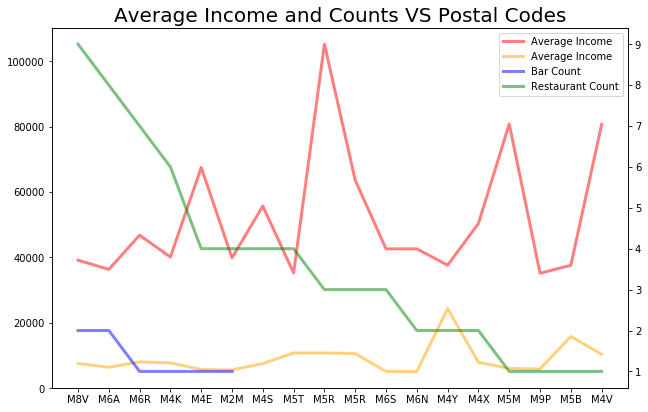

In [22]:
# Plot three lines with different scales on the same plot
fig = plt.figure(figsize=(8, 5))
line_weight = 3
alpha = .5
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes()
# This joins the x-axis.
ax2 = ax1.twinx()
lns1a = ax1.plot(df6['Average Income'], color='red', lw=line_weight, alpha=alpha, label='Average Income')
lns1b = ax1.plot(df6['Density (people/km2)'], color='orange', lw=line_weight, alpha=alpha, label='Average Income')
lns2a = ax2.plot(df_bars['Counts'], color='blue', lw=line_weight, alpha=alpha, label='Bar Count')
lns2b = ax2.plot(df_restaurants['Counts'], color='green', lw=line_weight, alpha=alpha, label='Restaurant Count')
# Solution for having two legends
leg = lns1a + lns1b + lns2a + lns2b
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc=0)
plt.title('Average Income and Counts VS Postal Codes', fontsize=20)
plt.xticks(df6.index, df6['Postal Code'])
plt.show()


It seems there are a decent amount of areas that have a high average income, high number of restaurants, and low number of bars. Let's take a look at the postal Codes "M5R" as it seems to have everything we need. Let's map it out and see where this potential location is.

In [23]:
M5R = df5_filtered['Postal Code'] == 'M5R'
df5_filtered1 = df5_filtered[M5R]
df5_filtered1.head()

Neighbourhood  Population  Density (people/km2)  Average Income  \
0     Yorkville        6045                 10795          105239   
4     The Annex       15602                 10614           63636   

   Transit Commuting %\n Highest 2nd Language Postal Code          Borough  \
0                   18.3         01.9% French         M5R  Central Toronto   
4                   22.1        01.3% Spanish         M5R  Central Toronto   

   Latitude  Longitude                                           URL Link  
0  43.67271 -79.405678  https://api.foursquare.com/v2/venues/explore?&...  
4  43.67271 -79.405678  https://api.foursquare.com/v2/venues/explore?&...

In [258]:
neighborhoods = df5_filtered1

print('The geograpical coordinate of The Annex are {}, {}.'.format(latitude, longitude))

# create map of Toronto using latitude and longitude values
map_toronto_venues = folium.Map(location=[43.67271, -79.405678], zoom_start=14)


# add restaurant markers to map
for lat, lng, name, category in zip(restaurants['Latitude'], restaurants['Longitude'], restaurants['Name'], restaurants['Category']):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_opacity=0.5,
        parse_html=False).add_to(map_toronto_venues)
    
# add bar markers to map
for lat, lng, name, category in zip(bars['Latitude'], bars['Longitude'], bars['Name'], bars['Category']):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_opacity=0.5,
        parse_html=False).add_to(map_toronto_venues)

# add neighborhood circles to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=1500,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.1,
        parse_html=False).add_to(map_toronto_venues)  

map_toronto_venues



The geograpical coordinate of The Annex are 43.653963, -79.387207.


It seems that looking at the map, we can also verify that the results; there are many restaunts and few bars in the area.

# Results & Discussion <a name="results"></a>

The results show that there are a number of neighbourhoods in Toronto suitable for the potential opening of a bar/club. However, the one neighbourhood that did stand out above the rest was the The Annex. It had one of the highest average incomes, high a high population density, a high number of restaurants, and a low number of bars. The Annex, by far, is the best choice when analyzing this data with those metrics.

As enjoyable as this was, there were a lot of mistakes and factors overlooked while going through this project. First, what makes a suitable location for a restaurant? It was automatically assumed that those four factors are corrrelated with the success of a restaurant. Among other things, if this project were to be done again, much more effort would be put into research and diving deeper into figuring out what the actual problem is rather than just assuming.

Secondly, a lot of the Postal Code that FourSquare provided was incomplete. Therefore, as we continued to narrow down results and filter them, data was omitted due to the incompleteness. Once again, the data is the most important, so if done again, I would spend a lot more time gathering data using similar API's such as google maps, etc.


Thirdly, the classification of bars and restaurants were based off keywords that I simply thought of on the spot. Had I known that lack of classification by FourSquare, I would have taken a different route to classify bars and restaurants.

Lastly, the analysis, due to my lack of Python knowledge was quite simple and did not show any advanced analytical techniques. If I were to repeat this project, I would want to add a polynomial regression that shows the correlation between multiple factors.

# Conclusion<a name="conclusion"></a>

The project was to find a suitable location for a bar in Toronto by looking at four metrics in order to aid potential investors. By scraping data off the web and also using Foursquare, the data was scrubbed, merged, mapped, and then finally analyzed. Add the end, a suitable location that met the criteria for all 4 metrics was found in The Annex neighbourhood in downtown Toronto.

There are many more optics to be looked at when deciding on the bar location. Other factors to take into consideration may include but not limited to: demographics of neighbourhoods, noise level, crime activity, accessibility via public transportation, rent price.

Overall, this project was quite interesting and it definitely helped me to expand my python knowledge as well as problem solving skills. However, the most important aspect for me was that it was enjoyable. I hope to increase my data science skills further and also pursue a career in this field. AI